In [12]:
from __future__ import division
import numpy as np
from data_reader import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import copy
from pulp import *

%matplotlib inline

In [2]:
warning_path = 'data/warnings/'
warning_name = '05182017.csv'
warnings_05182017 = read_data(warning_path+warning_name)
warnings_05182017 = warnings_05182017[28:27655+28,:]
print(warnings_05182017.shape)

warning_name = '10152017.csv'
warnings_10152017 = read_data(warning_path+warning_name)
print(warnings_10152017.shape)

warning_name = '10172017.csv'
warnings_10172017 = read_data(warning_path+warning_name)
print(warnings_10172017.shape)

warning_name = '10172017_freeway.csv'
warnings_10172017_freeway = read_data(warning_path+warning_name)
print(warnings_10172017_freeway.shape)

(27655, 18)
(19137, 18)
(40646, 18)
(79585, 18)


In [3]:
anomaly_path = 'data/anomalies/'
anomaly_name = '05182017.csv'
anomalies_05182017 = read_data(anomaly_path+anomaly_name)
print(anomalies_05182017.shape)

anomaly_name = '10152017.csv'
anomalies_10152017 = read_data(anomaly_path+anomaly_name)
print(anomalies_10152017.shape)

anomaly_name = '10172017.csv'
anomalies_10172017 = read_data(anomaly_path+anomaly_name)
print(anomalies_10172017.shape)

anomaly_name = '10172017_freeway.csv'
anomalies_10172017_freeway = read_data(anomaly_path+anomaly_name)
print(anomalies_10172017_freeway.shape)

(27655, 5)
(19137, 5)
(40646, 5)
(79585, 5)


In [4]:
warnings = np.vstack([warnings_05182017, warnings_10152017, warnings_10172017, warnings_10172017_freeway])
anomalies = np.vstack([anomalies_05182017, anomalies_10152017, anomalies_10172017, anomalies_10172017_freeway])
print(warnings.shape)
print(anomalies.shape)

(167023, 18)
(167023, 5)


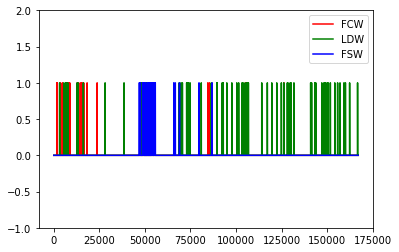

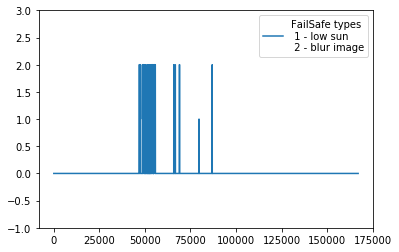

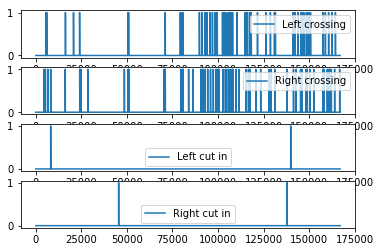

In [5]:
'''
Read and process the warning signals
'''
FCW = warnings[:,1].astype(int)# Forward Collision Warning
LLDW = warnings[:,2].astype(int) # Left Lane Departure Warning
RLDW = warnings[:,3].astype(int) # Right Lane Departure Warning
LDW = LLDW|RLDW 
FSW = warnings[:,4].astype(int) # FailSafe Warning
FSType = warnings[:,5].astype(int) # FailSafe Types

LCrossing = warnings[:,7]
RCrossing = warnings[:,8]
LCutIn = warnings[:,9]
RCutIn = warnings[:,10]

plt.figure(1)
plt.plot(FCW,'r')
plt.plot(LDW,'g')
plt.plot(FSW,'b')
plt.ylim([-1,2])
plt.legend(['FCW','LDW','FSW'])

plt.figure(2)
plt.plot(FSType)
plt.ylim([-1,3])
plt.legend(['FailSafe types\n 1 - low sun\n 2 - blur image'])

plt.figure(3)
plt.subplot(411)
plt.plot(LCrossing)
plt.legend(['Left crossing'])
plt.subplot(412)
plt.plot(RCrossing)
plt.legend(['Right crossing'])
plt.subplot(413)
plt.plot(LCutIn)
plt.legend(['Left cut in'])
plt.subplot(414)
plt.plot(RCutIn)
plt.legend(['Right cut in'])

In [6]:
'''Compute probabilities of Warning variables, as value of data'''
three_warnings = np.hstack([np.reshape(FCW,(len(FCW),1)),np.reshape(LDW,(len(LDW),1)),np.reshape(FSW,(len(FSW),1))])
states_list,state_counts = np.unique(three_warnings,axis=0,return_counts=True)
print (states_list)
print (state_counts)
p_list = state_counts/three_warnings.shape[0]
print (p_list)
value_list = -np.log2(p_list)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]
[162096   4028    747    152]
[  9.70501069e-01   2.41164391e-02   4.47243793e-03   9.10054304e-04]


In [25]:
'''Compute information entropy '''
entropy = np.zeros(3)
for i in range(3):
    unique_states,state_counts = np.unique(three_warnings[:,i],return_counts=True)
    probs = state_counts/three_warnings.shape[0]
    print(state_counts)
    entropy[i] = -np.sum(probs * np.log2(probs))
entropy

[166871    152]
[166276    747]
[162995   4028]


array([ 0.01050548,  0.04134405,  0.16396758])

In [7]:
def gaussian_func(x,a,mu,sigma):
    return a*np.exp(-((x-mu)**2)/(2*sigma**2))
def score_filter(raw_score,sigma):
    j = 0
    N = raw_score.shape[0]
    filtered_score = copy.deepcopy(raw_score)
    for i,score in enumerate(raw_score):
        if j > 0:
            if raw_score[j] > raw_score[j-1]:
                mu = j
                start_idx = np.max([mu - 3*sigma,0])
                a = raw_score[j] - raw_score[j-1]
                for k in range(start_idx,mu):
                    filtered_score[k] = np.max([filtered_score[k],gaussian_func(k,a,mu,sigma)])
            elif raw_score[j] < raw_score[j-1]:
                mu = j
                end_idx = np.min([mu + 3*sigma,N])
                a = raw_score[j-1] - raw_score[j]
                for k in range(mu,end_idx):
                    filtered_score[k] = np.max([filtered_score[k],gaussian_func(k,a,mu,sigma)])
        j += 1
    return filtered_score

def compute_raw_score(states_list,state,value_list):
    tmp_i = np.where((states_list == state).all(axis=1))[0]
    return value_list[tmp_i]

<function matplotlib.pyplot.show>

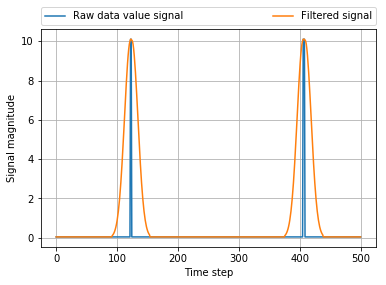

In [10]:
'''Data value filtering, only for example plot purpose'''
sigma = 10
raw_score = []
N = 500 # buffer size
    
for i in range(1500,2000):
    tmp_i = np.where((states_list == three_warnings[i,:] ).all(axis=1))[0]
    raw_score.append(value_list[tmp_i])
raw_score = np.array(raw_score)
filtered_score = score_filter(raw_score, sigma)
# filtered_score = gaussian_filter(raw_score, sigma)

plt.figure(1)
plt.plot(raw_score)
plt.plot(filtered_score)
plt.legend(['Raw data value signal', 'Filtered signal'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Signal magnitude')
plt.grid(True)
plt.savefig('filtered_signal.png',dpi=500,bbox_inches='tight')
plt.show

In [40]:
qqqq = [0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0]
tttt = gaussian_filter(qqqq, 1)
print(qqqq)
print(tttt)

[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


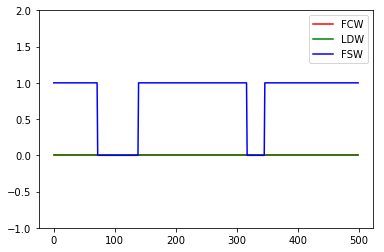

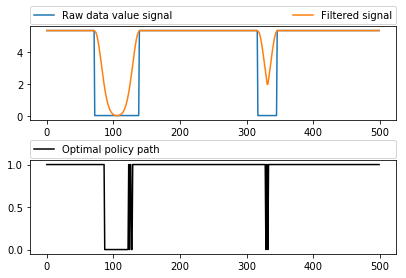

In [42]:
'''Run moving horizon optimization'''

buf_size = 500
eta = 5
sigma = 10
memo_max = 10000
moving_buf = {}
moving_buf['size'] = []
moving_buf['value'] = []
moving_buf['state'] = []
optimal_policy = []
k = 0
memo_tracker = 0
all_filtered_scores = []
all_raw_scores = []
test_data = three_warnings[47000:47500,:]#[15200:15400,:]
num_data = test_data.shape[0]

for i,state in enumerate(test_data):
    moving_buf['state'].append(test_data[i,:])
    moving_buf['value'].append(compute_raw_score(states_list,test_data[i,:],value_list))
    moving_buf['size'].append(float(2*np.random.randn(1)+10)) # assume the img size follows a normal distribution
    if len(moving_buf['value']) == buf_size or i == num_data-1: # start to optimize if buffer is full or there is no new frame
        buf_length = len(moving_buf['value'])
        '''Filter the score'''
        filtered_score = score_filter(np.array(moving_buf['value']), sigma)
        '''Optimize'''
        pi = []
        prob = LpProblem("Optimal policy", LpMinimize)
        # Add objective function
        for j in range(buf_length):
            pi.append(LpVariable(str(j),0, 1,cat='Integer'))
            if j == 0:
                obj_func = pi[j]*(moving_buf['size'][j]-eta*filtered_score[j])
            else:
                obj_func += pi[j]*(moving_buf['size'][j]-eta*filtered_score[j])
        prob += obj_func
        # Add constraints
        for j in range(buf_length):
            if j == 0:
                constrain_func = pi[j] * moving_buf['size'][j]
            else:
                constrain_func += pi[j] * moving_buf['size'][j]
        prob += constrain_func <= np.max([memo_max - memo_tracker,0])
        prob.solve()
        
        '''Sort the optimization results to get optimal policies'''
        array_to_sort = np.zeros([buf_length,2])
        for j,v in enumerate(prob.variables()):
            array_to_sort[j,0] = int(v.name)
            array_to_sort[j,1] = int(v.varValue)
        sorted_idx = np.argsort(array_to_sort[:,0])
        sorted_action = array_to_sort[sorted_idx,1]
        
        '''Save data, update storage capacity'''
        memo_tracker += float(np.dot(sorted_action,np.array(moving_buf['size'])))
        
        '''Append the sorted action to the whole action list'''
        if k == 0:
            optimal_policy = sorted_action
            all_filtered_scores = filtered_score
            all_raw_scores = np.array(moving_buf['value'])
        else:
            optimal_policy = np.append(optimal_policy, sorted_action)
            all_filtered_scores = np.append(all_filtered_scores, filtered_score)
            all_raw_scores = np.append(all_raw_scores, np.array(moving_buf['value']))
            
        k += 1
        moving_buf['size'] = []
        moving_buf['value'] = []
        moving_buf['state'] = []

plt.figure(1)
plt.plot(test_data[:,0],'r')
plt.plot(test_data[:,1],'g')
plt.plot(test_data[:,2],'b')
plt.ylim([-1,2])
plt.legend(['FCW','LDW','FSW'])

plt.figure(2)
plt.subplot(211)
plt.plot(all_raw_scores)
plt.plot(all_filtered_scores)
plt.legend(['Raw data value signal', 'Filtered signal'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('data_value_signal.png',dpi=500)

# plt.figure(3)
plt.subplot(212)
plt.plot(optimal_policy,'k')
plt.legend(['Optimal policy path'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout(pad=2)

# plt.savefig('value_and_bad_policy.png',dpi=500)


ImportError: No module named picos

[False False False ..., False False False]


<function matplotlib.pyplot.show>

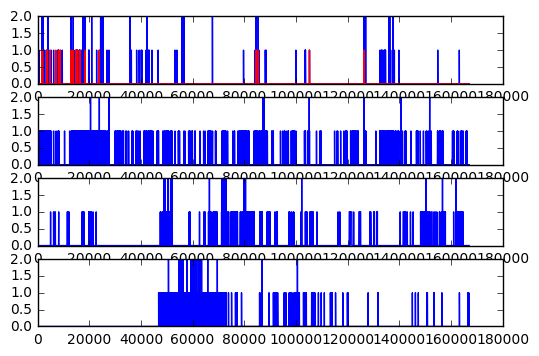

In [7]:
'''
Process computed anomaly scores
'''
thresh1 = 0.7
thresh2 = 0.3
time = anomalies[:,0]
Rt = anomalies[:,1] / np.max(anomalies[:,1])
Rd = anomalies[:,2] / np.max(anomalies[:,2])
Rb = anomalies[:,3] / np.max(anomalies[:,3])
Ro = anomalies[:,4] / np.max(anomalies[:,4])

print(Rt>thresh1)

Rt[Rt>thresh1] = 2
Rt[Rt<thresh2] = 0
Rt[np.array(Rt>thresh2) & np.array(Rt<thresh1)] = 1

Rd[Rd>thresh1] = 2
Rd[Rd<thresh2] = 0
Rd[np.array(Rd>thresh2) & np.array(Rd<thresh1)] = 1

Rb[Rb>thresh1] = 2
Rb[Rb<thresh2] = 0
Rb[np.array(Rb>thresh2) & np.array(Rb<thresh1)] = 1

Ro[Ro>thresh1] = 2
Ro[Ro<thresh2] = 0
Ro[np.array(Ro>thresh2) & np.array(Ro<thresh1)] = 1

plt.figure(1)
plt.subplot(411)
plt.plot(Rt)
plt.plot(FCW,'r')
plt.subplot(412)
plt.plot(Rd)
plt.subplot(413)
plt.plot(Rb)
plt.subplot(414)
plt.plot(Ro)
plt.show

In [47]:
# from scipy.optimize import linprog
# size = np.random.rand(10)
# value = np.random.randint(2, size=10)
# x = linprog(size-value,A_ub=np.reshape(size,(1,10)), b_ub=np.array([5]), )

'''Use PULP for Integer Linear Programming'''
from pulp import *
mu = 10
sigma = 2
size = 2*np.random.randn(100)+10
value = np.random.randint(3, size=100)
b = 0
a = []
prob = LpProblem("test1", LpMinimize)
for i in range(100):
    a.append(LpVariable(str(i),0, 1,cat='Integer'))
    if i == 0:
        b = a[i]*(size[i]-5*value[i])
    else:
        b += a[i]*(size[i]-5*value[i])
prob += b
prob.solve()

1

<function matplotlib.pyplot.show>

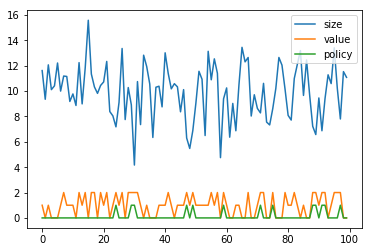

In [48]:
'''Read optimized policies and plot'''
array_to_sort = np.zeros([100,2])
for i,v in enumerate(prob.variables()):
    array_to_sort[i,0] = int(v.name)
    array_to_sort[i,1] = int(v.varValue)
#     print("idx:", v.name)
#     print("policy:",v.varValue)
sorted_idx = np.argsort(array_to_sort[:,0])
sorted_array = array_to_sort[sorted_idx,:]
plt.figure(1)
plt.plot(size)
plt.plot(value)
plt.plot(sorted_array[:,1])
plt.legend(['size','value','policy'])
plt.show

(3, 167023)
(167023, 3)
[[ 1.         -0.00202291 -0.00474448]
 [-0.00202291  1.         -0.01053666]
 [-0.00474448 -0.01053666  1.        ]]
[[ 1.         -0.00202291 -0.00474448  0.0719048   0.03058795 -0.00714665
  -0.00279222]
 [-0.00202291  1.         -0.01053666 -0.00381921 -0.00927268  0.01202795
   0.00469484]
 [-0.00474448 -0.01053666  1.         -0.00594265 -0.02711329  0.04447281
   0.07629097]
 [ 0.0719048  -0.00381921 -0.00594265  1.          0.04310731 -0.00741626
  -0.00527165]
 [ 0.03058795 -0.00927268 -0.02711329  0.04310731  1.         -0.03050837
  -0.01556427]
 [-0.00714665  0.01202795  0.04447281 -0.00741626 -0.03050837  1.
   0.00409528]
 [-0.00279222  0.00469484  0.07629097 -0.00527165 -0.01556427  0.00409528
   1.        ]]


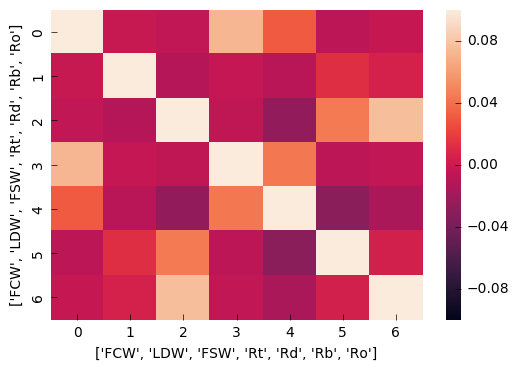

In [10]:
system_warnings = np.vstack([FCW, LDW, FSW])
print (system_warnings.shape)
system_warnings = system_warnings.T
print (system_warnings.shape)
warning_corr = np.corrcoef(system_warnings, rowvar=False)
print (warning_corr)

warning_anomaly = np.vstack([FCW, LDW, FSW, Rt, Rd, Rb, Ro]) # remove FSW since it was a constant in 05182017 data
warning_anomaly = warning_anomaly.T
warning_anomaly_corr = np.corrcoef(warning_anomaly, rowvar=False)

print (warning_anomaly_corr)

plt.figure(1)
sns.heatmap(warning_anomaly_corr,vmin=-0.1, vmax=0.1, cbar=True)
plt.xlabel(['FCW', 'LDW', 'FSW', 'Rt', 'Rd', 'Rb', 'Ro'])
plt.ylabel(['FCW', 'LDW', 'FSW', 'Rt', 'Rd', 'Rb', 'Ro'])
plt.show
plt.savefig('WA_correlation_matrix.png',dpi=500)

In [16]:
'''Compute transition matrix based on the data we have'''
state_space_size=648
state_index = 216*Ro+72*Rb+24*Rd+8*Rt+4*FSW+2*LDW+FCW+1
print(np.unique(state_index))
N = np.zeros([state_space_size,state_space_size])
T = np.eye(state_space_size)
simulation_time = int(1e7)
total_num = Ro.shape[0]
for i in range(simulation_time):
    j = np.random.randint(total_num-1)
    N[state_index[j],state_index[j+1]] += 1
for i in range(state_space_size):
    if np.sum(N[i,:]) != 0:
        T[i,:] = N[i,:]/np.sum(N[i,:])

print("Approximated transition matrix", T)

[   1.    2.    3.    5.    9.   10.   13.   17.   18.   25.   26.   27.
   29.   33.   34.   41.   42.   49.   73.   75.   77.   81.   97.   99.
  101.  105.  145.  149.  169.  217.  219.  221.  241.  289.  291.  293.
  313.  317.  361.  433.  437.  457.  505.]


/Users/BrianYao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('Approximated transition matrix', array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.77091065e-01,   8.64609925e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.21576486e-01,   7.69205077e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]))


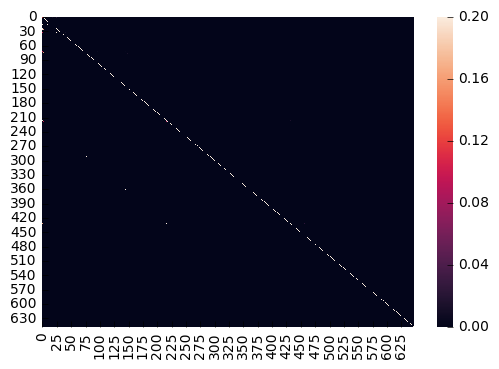

In [20]:
plt.figure(1)
sns.heatmap(T,vmin=0, vmax=0.2, cbar=True)
plt.show
# plt.savefig('transition_matrix.png', dpi=1500)


In [5]:
'''
Load all experiment drivings and do statistics together
'''
import glob
warning_path = 'data/warnings/'
all_names = glob.glob(warning_path+'*.csv')
all_exps = []
for i, name in enumerate(all_names):
    exp_drive = read_data(name)
    if i == 0:
        all_exps = exp_drive
    else:
        all_exps = np.vstack([all_exps, exp_drive])
all_exps.shape

(132463, 18)

(3, 132463)
(132463, 3)
[[ 1.         -0.00242566 -0.00962562]
 [-0.00242566  1.         -0.0108524 ]
 [-0.00962562 -0.0108524   1.        ]]


<function matplotlib.pyplot.show>

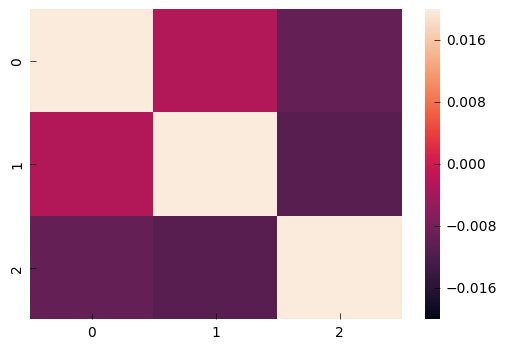

In [6]:
all_FCW = all_exps[:,1].astype(int)# Forward Collision Warning
all_LLDW = all_exps[:,2].astype(int) # Left Lane Departure Warning
all_RLDW = all_exps[:,3].astype(int) # Right Lane Departure Warning
all_LDW = all_LLDW|all_RLDW 
all_FSW = all_exps[:,4].astype(int) # FailSafe Warning
all_FSType = all_exps[:,5].astype(int) # FailSafe Types

all_LCrossing = all_exps[:,7]
all_RCrossing = all_exps[:,8]
all_LCutIn = all_exps[:,9]
all_RCutIn = all_exps[:,10]

all_system_warnings = np.vstack([all_FCW, all_LDW, all_FSW])
print (all_system_warnings.shape)
all_system_warnings = all_system_warnings.T
print (all_system_warnings.shape)

warning_corr = np.corrcoef(all_system_warnings, rowvar=False)
print (warning_corr)

plt.figure(1)
sns.heatmap(warning_corr,vmin=-0.02, vmax=0.02, cbar=True)
plt.show

[0 0 0 ..., 0 0 0]


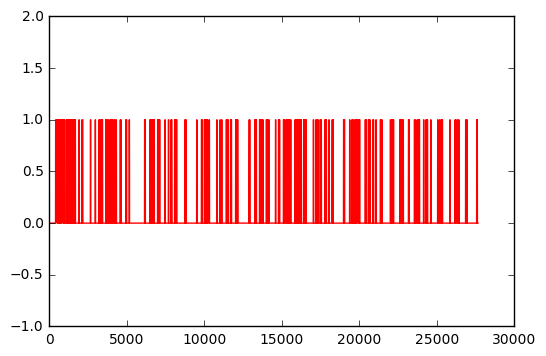

In [11]:
'''
Load optimal action for 05182017 trajectory and compare with warning/anomalies
'''
optimal_action_path = []
with open('optimal_action.txt') as f:
    lines = f.readlines()
    for line in lines:
        optimal_action_path.append(int(line.strip()))
optimal_action_path = np.array(optimal_action_path)
print (optimal_action_path)
plt.figure(1)
plt.plot(optimal_action_path,'r')
plt.ylim([-1,2])
plt.show()